# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

8.1.0


<ipython-input-2-4c6081fb4fd8>:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Feb 06 11:28:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.82       Driver Version: 451.82       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |     76MiB /  3072MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [108]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [109]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [110]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        ])    
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [111]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [112]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [113]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [114]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
new_train_files = []
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
    new_train_files.extend(dct_path_train[person])
    print(person, len(dct_path_train[person]))

abraham_grampa_simpson 913
agnes_skinner 100
apu_nahasapeemapetilon 623
barney_gumble 106
bart_simpson 1342
carl_carlson 100
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 100
comic_book_guy 469
disco_stu 100
edna_krabappel 457
fat_tony 100
gil 100
groundskeeper_willie 121
homer_simpson 2246
kent_brockman 498
krusty_the_clown 1206
lenny_leonard 310
lionel_hutz 100
lisa_simpson 1354
maggie_simpson 128
marge_simpson 1291
martin_prince 100
mayor_quimby 246
milhouse_van_houten 1079
miss_hoover 100
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 358
otto_mann 100
patty_bouvier 100
principal_skinner 1194
professor_john_frink 100
rainier_wolfcastle 100
ralph_wiggum 100
selma_bouvier 103
sideshow_bob 877
sideshow_mel 100
snake_jailbird 100
troy_mcclure 100
waylon_smithers 181


In [115]:
len(new_train_files)

21887

In [116]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [117]:
random_characters = int(np.random.uniform(0,1000))
im_val, label = val_dataset[random_characters]

Давайте посмотрим на наших героев внутри датасета.

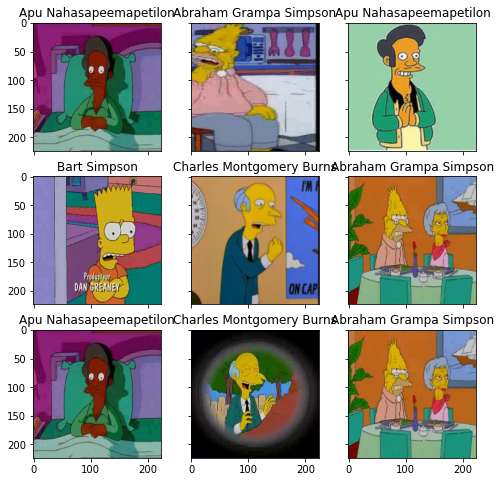

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
#flatten() преобразовывает массивы в одномерный вектор
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [119]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [120]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [121]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [122]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [123]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [124]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [125]:
import torchsummary

In [126]:
torchsummary.summary(simple_cnn.cuda(), (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 111, 111]         --
|    └─Conv2d: 2-1                       [-1, 8, 222, 222]         224
|    └─BatchNorm2d: 2-2                  [-1, 8, 222, 222]         16
|    └─ReLU: 2-3                         [-1, 8, 222, 222]         --
|    └─MaxPool2d: 2-4                    [-1, 8, 111, 111]         --
├─Sequential: 1-2                        [-1, 16, 54, 54]          --
|    └─Conv2d: 2-5                       [-1, 16, 109, 109]        1,168
|    └─BatchNorm2d: 2-6                  [-1, 16, 109, 109]        32
|    └─ReLU: 2-7                         [-1, 16, 109, 109]        --
|    └─MaxPool2d: 2-8                    [-1, 16, 54, 54]          --
├─Sequential: 1-3                        [-1, 32, 26, 26]          --
|    └─Conv2d: 2-9                       [-1, 32, 52, 52]          4,640
|    └─BatchNorm2d: 2-10                 [-1, 32, 52, 52]          64
|    └─R

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 111, 111]         --
|    └─Conv2d: 2-1                       [-1, 8, 222, 222]         224
|    └─BatchNorm2d: 2-2                  [-1, 8, 222, 222]         16
|    └─ReLU: 2-3                         [-1, 8, 222, 222]         --
|    └─MaxPool2d: 2-4                    [-1, 8, 111, 111]         --
├─Sequential: 1-2                        [-1, 16, 54, 54]          --
|    └─Conv2d: 2-5                       [-1, 16, 109, 109]        1,168
|    └─BatchNorm2d: 2-6                  [-1, 16, 109, 109]        32
|    └─ReLU: 2-7                         [-1, 16, 109, 109]        --
|    └─MaxPool2d: 2-8                    [-1, 16, 54, 54]          --
├─Sequential: 1-3                        [-1, 32, 26, 26]          --
|    └─Conv2d: 2-9                       [-1, 32, 52, 52]          4,640
|    └─BatchNorm2d: 2-10                 [-1, 32, 52, 52]          64
|    └─R

In [127]:
from torchsummary import summary

In [128]:
summary(simple_cnn)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─BatchNorm2d: 2-2                  16
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       1,168
|    └─BatchNorm2d: 2-6                  32
|    └─ReLU: 2-7                         --
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       4,640
|    └─BatchNorm2d: 2-10                 64
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      18,496
|    └─BatchNorm2d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                        --
|    └─Conv2d: 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─BatchNorm2d: 2-2                  16
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       1,168
|    └─BatchNorm2d: 2-6                  32
|    └─ReLU: 2-7                         --
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       4,640
|    └─BatchNorm2d: 2-10                 64
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      18,496
|    └─BatchNorm2d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                        --
|    └─Conv2d: 

Запустим обучение сети.

In [129]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.45149753510056


epoch:  10%|█         | 1/10 [03:48<34:18, 228.68s/it]


Epoch 001 train_loss: 2.4515     val_loss 1.5596 train_acc 0.3331 val_acc 0.5743
loss 1.2402930022996237


epoch:  20%|██        | 2/10 [07:39<30:34, 229.32s/it]


Epoch 002 train_loss: 1.2403     val_loss 0.8293 train_acc 0.6638 val_acc 0.7723
loss 0.7449600624845882


epoch:  30%|███       | 3/10 [11:40<27:10, 232.91s/it]


Epoch 003 train_loss: 0.7450     val_loss 0.5316 train_acc 0.7927 val_acc 0.8429
loss 0.4176459865729762


epoch:  40%|████      | 4/10 [15:09<22:33, 225.61s/it]


Epoch 004 train_loss: 0.4176     val_loss 0.3329 train_acc 0.8832 val_acc 0.9064
loss 0.3093749658420478


epoch:  50%|█████     | 5/10 [18:55<18:48, 225.70s/it]


Epoch 005 train_loss: 0.3094     val_loss 0.2211 train_acc 0.9122 val_acc 0.9398
loss 0.2265369266110917


epoch:  60%|██████    | 6/10 [22:35<14:56, 224.14s/it]


Epoch 006 train_loss: 0.2265     val_loss 0.1590 train_acc 0.9343 val_acc 0.9570
loss 0.12464302255576616


epoch:  70%|███████   | 7/10 [26:10<11:03, 221.23s/it]


Epoch 007 train_loss: 0.1246     val_loss 0.0931 train_acc 0.9671 val_acc 0.9775
loss 0.09140268376330861


epoch:  80%|████████  | 8/10 [29:39<07:15, 217.71s/it]


Epoch 008 train_loss: 0.0914     val_loss 0.0669 train_acc 0.9764 val_acc 0.9859
loss 0.06991440086791595


epoch:  90%|█████████ | 9/10 [33:08<03:35, 215.04s/it]


Epoch 009 train_loss: 0.0699     val_loss 0.0564 train_acc 0.9824 val_acc 0.9855
loss 0.03823990328524636


epoch: 100%|██████████| 10/10 [36:48<00:00, 220.84s/it]


Epoch 010 train_loss: 0.0382     val_loss 0.0291 train_acc 0.9920 val_acc 0.9947


Построим кривые обучения

In [130]:
loss, acc, val_loss, val_acc = zip(*history)

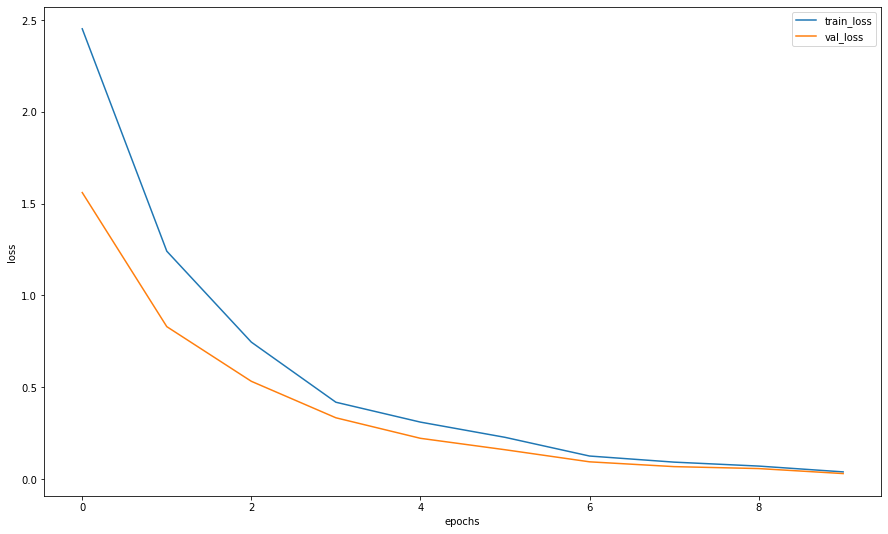

In [131]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [132]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [133]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [134]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [135]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [136]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [137]:
actual_labels

[0, 6, 0, 4, 4, 4, 4, 0, 6, 2, 4, 2, 4, 6, 4, 0, 0, 4, 0, 0]

In [138]:
y_pred

array([0, 6, 0, 4, 4, 4, 4, 0, 6, 2, 4, 2, 4, 6, 4, 0, 0, 4, 0, 0],
      dtype=int64)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [139]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

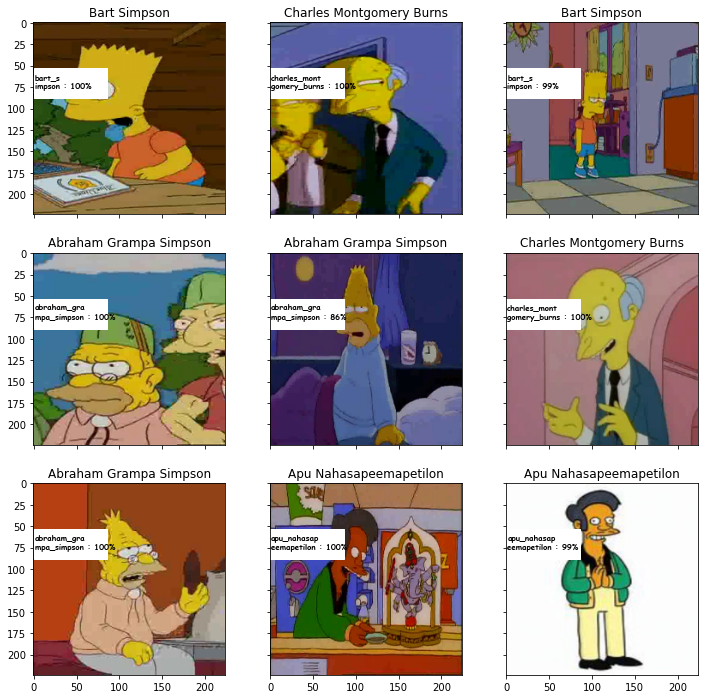

In [140]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [141]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [142]:
preds

array(['nelson_muntz', 'bart_simpson', 'ned_flanders', 'chief_wiggum',
       'apu_nahasapeemapetilon', 'kent_brockman', 'edna_krabappel',
       'chief_wiggum', 'lisa_simpson', 'kent_brockman', 'lenny_leonard',
       'marge_simpson', 'kent_brockman', 'ned_flanders', 'moe_szyslak',
       'comic_book_guy', 'abraham_grampa_simpson', 'edna_krabappel',
       'kent_brockman', 'lisa_simpson', 'marge_simpson', 'nelson_muntz',
       'comic_book_guy', 'mayor_quimby', 'homer_simpson',
       'apu_nahasapeemapetilon', 'krusty_the_clown', 'krusty_the_clown',
       'ned_flanders', 'edna_krabappel', 'apu_nahasapeemapetilon',
       'chief_wiggum', 'apu_nahasapeemapetilon', 'ned_flanders',
       'marge_simpson', 'abraham_grampa_simpson', 'homer_simpson',
       'sideshow_bob', 'lisa_simpson', 'charles_montgomery_burns',
       'chief_wiggum', 'kent_brockman', 'abraham_grampa_simpson',
       'milhouse_van_houten', 'lenny_leonard', 'abraham_grampa_simpson',
       'nelson_muntz', 'comic_book_guy

In [143]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [144]:
my_submit.sample(5)

,Id,Expected
412,img47.jpg,principal_skinner
52,img145.jpg,apu_nahasapeemapetilon
566,img608.jpg,apu_nahasapeemapetilon
325,img391.jpg,apu_nahasapeemapetilon
285,img355.jpg,principal_skinner


In [145]:
my_submit.to_csv('./my_submission3.csv', index=False)